**OBJECTIVE:** Run modSAR algorithm on OSM-S4 qsar dataset

In [9]:
import math
import scipy
import numpy as np
import pandas as pd

# Import relevant modSAR classes 
import modSAR
from modSAR.network_algorithms import ModSAR
from modSAR.dataset import QSARDataset, QSARDatasetIO

# plotnine is the python version of ggplot2
from plotnine import *

import warnings
warnings.filterwarnings("ignore")

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

from rdkit import RDLogger

import rdkit.Geometry
from rdkit.Chem import rdFMCS, PandasTools
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem import PandasTools

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# 2.5uM in Log units
CUTOFF_ACTIVITY = - np.log10(2.5e-06)

s4_template = Chem.MolFromSmarts('[#6]1:[#7]:[#6]:[#6]:[#7]2:[#6]:1:[#7]:[#7]:[#6]:2')
AllChem.Compute2DCoords(s4_template)

RDLogger.DisableLog('rdApp.info')

from rdkit.Chem import PandasTools

%matplotlib inline

# Context

**Author: Jonathan Cardoso-Silva (Github: @jonjoncardoso | Twitter: @jonjon_cardoso)**

In 2019, I participated in the [OSM-S4 predictive model competition](https://github.com/OpenSourceMalaria/Series4_PredictiveModel/issues/1) with a variation of [modSAR](https://doi.org/10.1007/s10822-019-00228-6), an algorithm I developed during my PhD at King's College London. Back then, I used [CDK 2.x](https://cdk.github.io/) library to compute ~200 molecular descriptors for every molecule in the dataset and produced a prediction model that did not perform too well - only 12 of 33 predictions in the hidden external data set were considered "correct". 

**_In this notebook, I revisit this modelling problem with the same algorithm but this time I am using molecular fingerprints (namely Morgan Fingerprints from RDKit) not just as a means to compute molecular similarity but also as features to the regression model._**

# Load Data

The dataset I am using here is made of Open Source Malaria Series4 (OSM-S4) molecules compiled by [@edwintse](https://github.com/OpenSourceMalaria/Series4_PredictiveModel/issues/1) and preprocessed by [@wvanhoorn](https://github.com/OpenSourceMalaria/Series4_PredictiveModel/issues/1#issuecomment-522630124).

This time, I am using Morgan fingerprints in two variantes, radius=2 and radius=4, as features to the regression model of modSAR which were generated in the `OSM-S4 - Notebook 01 - Preprocessing.ipynb`.

**Radius=2**

In [10]:
dataset_morgan2 = \
    QSARDatasetIO.load(dataset_name='OSM4',
                   activity_sheetname='activity',
                   smiles_column='Canonical_Smiles',
                   id_column='OSM_ID',
                   filepath='../data/osm_qsar_dataset_morgan2.xlsx',
                   calculate_similarity=False)
    

    
dataset_morgan2

QSARDataset OSM4 
 -- Samples : 347
 -- Features:  1024

Most importantly, these objects have a `X` and `y` dataframes representing the fingerprints and activity, respectively.

In [17]:
dataset_morgan2.X.iloc[0:2,:]

,Bit_0000,Bit_0001,Bit_0002,Bit_0003,Bit_0004,Bit_0005,Bit_0006,Bit_0007,Bit_0008,Bit_0009,Bit_0010,Bit_0011,Bit_0012,Bit_0013,Bit_0014,Bit_0015,Bit_0016,Bit_0017,Bit_0018,Bit_0019,Bit_0020,Bit_0021,Bit_0022,Bit_0023,Bit_0024,Bit_0025,Bit_0026,Bit_0027,Bit_0028,Bit_0029,Bit_0030,Bit_0031,Bit_0032,Bit_0033,Bit_0034,Bit_0035,Bit_0036,Bit_0037,Bit_0038,Bit_0039,...,Bit_0984,Bit_0985,Bit_0986,Bit_0987,Bit_0988,Bit_0989,Bit_0990,Bit_0991,Bit_0992,Bit_0993,Bit_0994,Bit_0995,Bit_0996,Bit_0997,Bit_0998,Bit_0999,Bit_1000,Bit_1001,Bit_1002,Bit_1003,Bit_1004,Bit_1005,Bit_1006,Bit_1007,Bit_1008,Bit_1009,Bit_1010,Bit_1011,Bit_1012,Bit_1013,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
OSM_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OSM-A-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
OSM-A-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


**Radius = 4**

In [2]:
dataset_morgan4 = \
    QSARDatasetIO.load(dataset_name='OSM4',
                   activity_sheetname='activity',
                   smiles_column='Canonical_Smiles',
                   id_column='OSM_ID',
                   filepath='../data/osm_qsar_dataset_morgan4.xlsx',
                   calculate_similarity=False)
    
dataset_morgan4

QSARDataset OSM4 
 -- Samples : 347
 -- Features:  1024

# Distribution of binary fingerprints

In [80]:
plot_df = pd.melt(dataset_morgan2.X.reset_index(), id_vars='OSM_ID')
plot_df = plot_df.groupby(['OSM_ID', 'variable']).sum().reset_index()
plot_df['OSM_ID'] = plot_df['OSM_ID'].apply(lambda x: x[0:9])
plot_df.groupby(['variable']).sum().reset_index().sort_values('value', ascending=False)

,variable,value
849,Bit_0849,347
356,Bit_0356,347
726,Bit_0726,339
935,Bit_0935,310
378,Bit_0378,304
...,...,...
720,Bit_0720,0
153,Bit_0153,0
154,Bit_0154,0
709,Bit_0709,0


**Are there any missing values?** No :)

In [4]:
sum(dataset_morgan4.X.isnull().sum(axis=1) > 0)

0

**Visualize a sample of the dataset**

,Canonical_Smiles,Series,Molecule,Bits
OSM_ID,,,,
OSM-S-175,FC(F)Oc1ccc(cc1)c2nnc3cncc(C(=O)Nc4ccnc(c4)C(F...,4,,0100000000000000000000000010000000000000000000...
OSM-S-177,FC(F)Oc1ccc(cc1)c2nnc3cncc(C(=O)N4Cc5ccccc5C4)n23,4,,0100000000000000000000000010000000000000000000...
OSM-S-187,N#Cc1ccc(cc1)c2nnc3cncc(OCCc4ccccc4)n23,4,,0000000000000100000001000000000000100000001000...

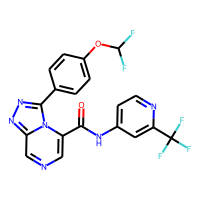
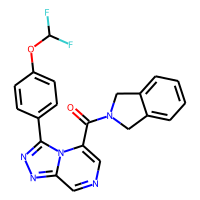
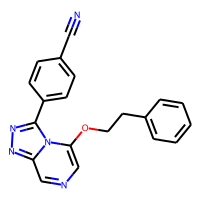

In [11]:
from rdkit.Chem import PandasTools

sample = dataset_morgan2.metadata.query("Series == '4'").iloc[0:3,:][["Canonical_Smiles", "Series"]].copy()
PandasTools.AddMoleculeColumnToFrame(sample,'Canonical_Smiles','Molecule',includeFingerprints=True)
sample = pd.merge(sample, dataset_morgan2.X, 
                  how="left", left_index=True, right_index=True)

bit_cols = [col for col in sample.columns if 'Bit' in col]
sample["Bits"] = sample.apply(lambda x: ''.join([str(x[col]) for col in bit_cols]), axis=1)
sample.drop(columns=bit_cols, inplace=True)
sample

In [9]:
selected_ids = ["OSM-S-5", "OSM-S-6", "OSM-S-106", "OSM-S-396", "OSM-S-175"]

for mol_id in selected_ids:
    mol = Chem.MolFromSmiles(dataset_morgan4.metadata.Canonical_Smiles.loc[mol_id])
    Draw.MolToFile(mol, "../data/{}.png".format(mol_id), size=(250,150), useSVG=False)

\#TODO A note to future self: To avoid creating a csv/xls file with too many columns, consider saving a single column with a string representing the on-off bits as above 

# Train ModSAR algorithm

ModSAR algorithm models regression algorithms in two stages:

1. Training data is represented as a **network** and divided into clusters by optimising the [modularity metric](https://python-louvain.readthedocs.io/en/latest/).
2. Each of this clusters (also called modules) are then modelled by the [OplraReg](https://onlinelibrary.wiley.com/doi/10.1002/minf.201800028) algorithm, a [segmented (or piecewise) regression model](https://www.theanalysisfactor.com/segmented-regression-for-non-constant-relationships/) with a regularisation penalty to select most relevant features and reduce overfitting.


ModSAR inherits a couple of parameters from OplraReg but in practice, we only need to tune $\lambda$ to define how big the effect of regularisation will be in the final piecewise linear equations. A higher $\lambda$ will lead to fewer features in the piecewise linear models and it will run quecker but if $\lambda$ is set too high, the model will have a huge bias and usually "underfit" the data. [Bias-variance tradeoff](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229).

## Cross-Validation

In this section, we will perform a cross-validation while searching for an optimum $\lambda$ parameter of modSAR.


Based on previous knowledge, we know this parameter to be optimally placed around $\lambda \approx 0.005$ - no fewer than that - so I will be sampling this parameter from a random HalfNormal distribution, i.e. $\lambda \sim \text{HalfNormal}(\mu=0.005, \sigma=0.05)$.

Randomized Search and Cross-Validation is performed with scikit-learn's [RandomizedSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search):

In [12]:
from copy import deepcopy
from sklearn.model_selection import GridSearchCV

modsar_alg = ModSAR(lam=0.02, metadata=dataset_morgan4.metadata)

scoring = ["neg_mean_absolute_error", "neg_mean_squared_error", "r2"]
param_distributions = {"lam": scipy.stats.halfnorm(0.005, 0.05)}

param_grid = {"lam": [i/100 for i in range(1, 11)]}


model_morgan2 = GridSearchCV(deepcopy(modsar_alg), 
                             return_train_score=True,
                             param_grid=param_grid, 
                             scoring=scoring, 
                             refit="neg_mean_squared_error",
                             cv=5,
                             n_jobs=5,
                             verbose=3)

model_morgan4 = GridSearchCV(deepcopy(modsar_alg), 
                             return_train_score=True,
                             param_grid=param_grid, 
                             scoring=scoring, 
                             refit="neg_mean_squared_error",
                             cv=5,
                             n_jobs=5,
                             verbose=3)

### Dataset: Morgan (radius=2)

Gridsearch on this dataset will take ~ 11 minutes

In [53]:
model_morgan2.fit(dataset_morgan2.X, dataset_morgan2.y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Calculating fingerprints
Calculating similarity
Best Threshold = 0.20 | ACC = 0.848
Threshold: 0.2 | k: 0
Communities: Counter({'m05': 121, 'm06': 117, 'm01': 52, 'm03': 47, 'm07': 8, 'm02': 1, 'm04': 1})
Num. samples in comm m01: 52
OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 1
SELECTED FEATURES:
['Bit_0031', 'Bit_0036', 'Bit_0080', 'Bit_0140', 'Bit_0290', 'Bit_0332', 'Bit_0350', 'Bit_0389', 'Bit_0452', 'Bit_0480', 'Bit_0703', 'Bit_0745', 'Bit_0961', 'Bit_1017']

None

OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 2 f* = Bit_0031 (loop 1/14) ###########

OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 2 f* = Bit_0036 (loop 2/14) ###########

OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 2 f* = Bit_0080 (loop 3/14) ###########

OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 2 f* = Bit_0140 (loop 4/14) ###########

OplraRegularised(lam=0.06, so

GridSearchCV(cv=5,
             estimator=ModSAR(lam=0.02, metadata=           Unnamed: 0 Series  ... duplicated  mark_to_remove
OSM_ID                        ...                           
OSM-A-1             0      1  ...       True           False
OSM-A-2             2      1  ...       True           False
OSM-A-3             4      1  ...       True           False
OSM-E-1             6      1  ...      False           False
OSM-E-2             7      1  ...      False           False
...               ...    ...  ...        ...             ...
OSM-S-631         434   not4  ...      False           False
OSM-S-632         435   not4  ...      False           False
OSM-S-633         436   not4  ...      False           False
OSM-W-4           437   not4  ...       True           False
OSM-S-194         439     TB  ...      False           False

[347 rows x 25 columns]),
             n_jobs=5,
             param_grid={'lam': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
        

In [54]:
results_df = pd.DataFrame(model_morgan2.cv_results_)
results_df["param_lam"] = results_df["param_lam"].astype(float)

selected_cols = [col for col in results_df.columns if 'split' not in col and 'std' not in col]
#results_df.loc[:, selected_cols].sort_values("param_lam")

In [55]:
# Save model to disk

from sklearn.externals import joblib
joblib.dump(model_morgan2, "../data/model_modsar_morgan2.joblib")
results_df.to_csv("../data/model_modsar_morgan2_results.csv")

In [13]:
from sklearn.externals import joblib
model_morgan2 = joblib.load("../data/model_modsar_morgan2.joblib")

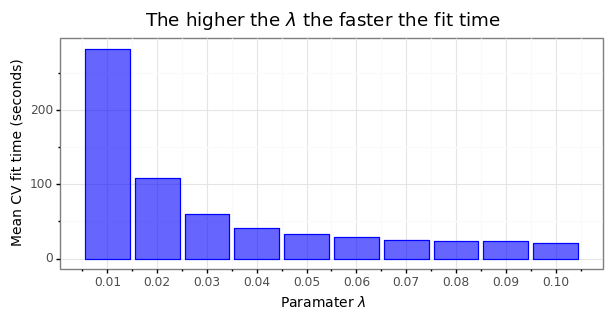

<ggplot: (-9223363283266171988)>

In [56]:
from plotnine import *

g = (ggplot(results_df, aes(x='param_lam', y="mean_fit_time")) + 
     geom_col(color="blue", fill="blue", alpha=0.6) +
     scale_x_continuous(name="Paramater $\lambda$",
                        breaks=[x/100 for x in range(13)]) +
     scale_y_continuous(name="Mean CV fit time (seconds)") +
     theme_bw() + 
     theme(figure_size = (7, 3), axis_title=element_text(size=10)) + 
     ggtitle("The higher the $\lambda$ the faster the fit time"))

g

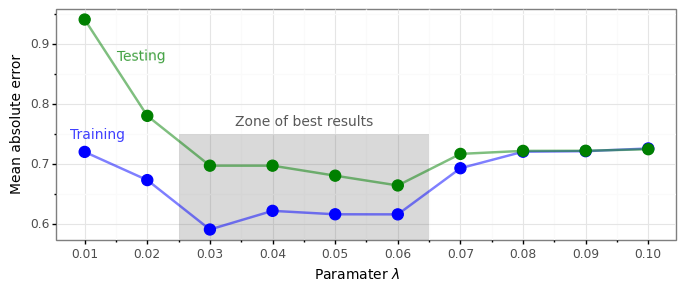

<ggplot: (-9223363283280168658)>

In [57]:
g = (ggplot(results_df, aes(x='param_lam')) + 
     geom_rect(xmin=0.025, xmax=0.065, ymin=0.5, ymax=0.75, fill='#212121', alpha=0.015) +
     geom_point(aes(y="-mean_train_neg_mean_absolute_error"), 
                size=4, color="blue", fill="blue", alpha=1) +
     geom_line(mapping=aes(y="-mean_train_neg_mean_absolute_error"), 
               size=1, color="blue", alpha=0.5) +
     geom_point(aes(y="-mean_test_neg_mean_absolute_error"), 
                size=4, color="green", fill="green", alpha=1) +
     geom_line(mapping=aes(y="-mean_test_neg_mean_absolute_error"), 
               size=1, color="green", alpha=0.5) +
     scale_x_continuous(name="Paramater $\lambda$", breaks=[x/100 for x in range(12)]) +
     scale_y_continuous(name="Mean absolute error") +
     annotate("text", label="Testing", color="green", 
              alpha=0.75, x=0.019, y=0.88, size=10, angle=1, fontweight="normal") +
     annotate("text", label="Training", color="blue", 
              alpha=0.75, x=0.012, y=0.75, size=10, angle=0, fontweight="normal") +
      annotate("text", label="Zone of best results", color="#212121", 
          alpha=0.75, x=0.045, y=0.771, size=10, fontweight="normal") +
     theme_bw() + 
     theme(figure_size = (8, 3), axis_title=element_text(size=10)))

g

**Evaluate fitting**

Apply modSAR predictions to the entire dataset, to assess fitting accuracy

MAE: 0.62 (+- 0.63)


<AxesSubplot:>

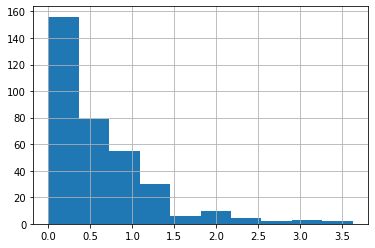

In [58]:
y_predicted = model_morgan2.predict(dataset_morgan2.X)
error = y_predicted - dataset_morgan2.y["pIC50"]

print("MAE: %.2f (+- %.2f)" % 
      (mean_absolute_error(dataset_morgan2.y, y_predicted),
       np.std(abs(error))))

pd.Series(abs(error)).hist()

### Dataset: Morgan (radius=4)

In [5]:
model_morgan4.fit(dataset_morgan4.X, dataset_morgan4.y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Calculating fingerprints
Calculating similarity
Best Threshold = 0.20 | ACC = 0.848
Threshold: 0.2 | k: 0
Communities: Counter({'m05': 121, 'm06': 117, 'm01': 52, 'm03': 47, 'm07': 8, 'm02': 1, 'm04': 1})
Num. samples in comm m01: 52
OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 1
SELECTED FEATURES:
['Bit_0031', 'Bit_0036', 'Bit_0080', 'Bit_0140', 'Bit_0290', 'Bit_0332', 'Bit_0350', 'Bit_0389', 'Bit_0452', 'Bit_0480', 'Bit_0703', 'Bit_0745', 'Bit_0961', 'Bit_1017']

None

OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 2 f* = Bit_0031 (loop 1/14) ###########

OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 2 f* = Bit_0036 (loop 2/14) ###########

OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 2 f* = Bit_0080 (loop 3/14) ###########

OplraRegularised(lam=0.06, solver_name='cplex')
########## R = 2 f* = Bit_0140 (loop 4/14) ###########

OplraRegularised(lam=0.06, so

GridSearchCV(cv=5,
             estimator=ModSAR(lam=0.02, metadata=           Unnamed: 0 Series  ... duplicated  mark_to_remove
OSM_ID                        ...                           
OSM-A-1             0      1  ...       True           False
OSM-A-2             2      1  ...       True           False
OSM-A-3             4      1  ...       True           False
OSM-E-1             6      1  ...      False           False
OSM-E-2             7      1  ...      False           False
...               ...    ...  ...        ...             ...
OSM-S-631         434   not4  ...      False           False
OSM-S-632         435   not4  ...      False           False
OSM-S-633         436   not4  ...      False           False
OSM-W-4           437   not4  ...       True           False
OSM-S-194         439     TB  ...      False           False

[347 rows x 25 columns]),
             n_jobs=5,
             param_grid={'lam': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
        

In [6]:
results_df = pd.DataFrame(model_morgan4.cv_results_)
results_df["param_lam"] = results_df["param_lam"].astype(float)

selected_cols = [col for col in results_df.columns if 'split' not in col and 'std' not in col]
#results_df.loc[:, selected_cols].sort_values("param_lam")

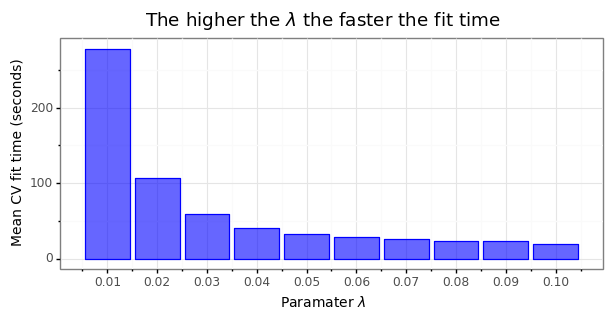

<ggplot: (8734334280968)>

In [7]:
from plotnine import *

g = (ggplot(results_df, aes(x='param_lam', y="mean_fit_time")) + 
     geom_col(color="blue", fill="blue", alpha=0.6) +
     scale_x_continuous(name="Paramater $\lambda$",
                        breaks=[x/100 for x in range(13)]) +
     scale_y_continuous(name="Mean CV fit time (seconds)") +
     theme_bw() + 
     theme(figure_size = (7, 3), axis_title=element_text(size=10)) + 
     ggtitle("The higher the $\lambda$ the faster the fit time"))

g

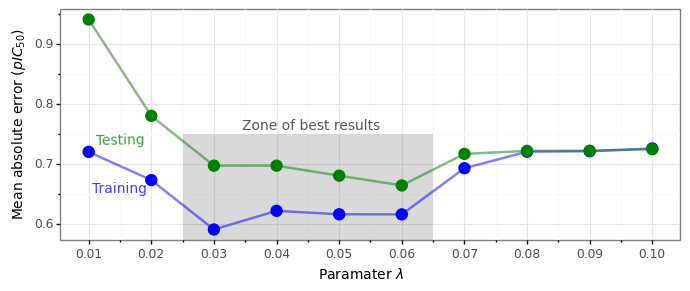

<ggplot: (-9223363302521012897)>

In [8]:
g = (ggplot(results_df, aes(x='param_lam')) + 
     geom_rect(xmin=0.025, xmax=0.065, ymin=0.5, ymax=0.75, fill='#212121', alpha=0.015) +
     geom_point(aes(y="-mean_train_neg_mean_absolute_error"), 
                size=4, color="blue", fill="blue", alpha=1) +
     geom_line(mapping=aes(y="-mean_train_neg_mean_absolute_error"), 
               size=1, color="blue", alpha=0.5) +
     geom_point(aes(y="-mean_test_neg_mean_absolute_error"), 
                size=4, color="green", fill="green", alpha=1) +
     geom_line(mapping=aes(y="-mean_test_neg_mean_absolute_error"), 
               size=1, color="green", alpha=0.5) +
     scale_x_continuous(name="Paramater $\lambda$", breaks=[x/100 for x in range(12)]) +
     scale_y_continuous(name="Mean absolute error ($pIC_{50}$)") +
     annotate("text", label="Testing", color="green", 
              alpha=0.75, x=0.015, y=0.74, size=10, angle=1, fontweight="normal") +
     annotate("text", label="Training", color="blue", 
              alpha=0.75, x=0.015, y=0.66, size=10, angle=0, fontweight="normal") +
      annotate("text", label="Zone of best results", color="#212121", 
          alpha=0.755, x=0.0455, y=0.765, size=10, fontweight="normal") +
     theme_bw() + 
     theme(figure_size = (8, 3), axis_title=element_text(size=10)))

g

In [9]:
# Save model to disk

from sklearn.externals import joblib
joblib.dump(model_morgan4, "../data/model_modsar_morgan4.joblib")
results_df.to_csv("../data/model_modsar_morgan4_results.csv")

In [154]:
from sklearn.externals import joblib
model_morgan4 = joblib.load("../data/model_modsar_morgan4.joblib")

**Evaluate fitting**

Apply modSAR predictions to the entire dataset, to assess fitting accuracy.

The second model, trained on Morgan fingerprints with radius=4 seem to have produced pretty similar but slightly better results

MAE: 0.62 (+- 0.63)


<AxesSubplot:>

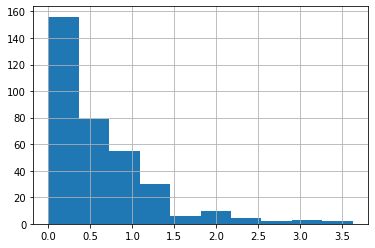

In [4]:
y_predicted = model_morgan4.predict(dataset_morgan4.X)
error = y_predicted - dataset_morgan4.y["pIC50"]
print("MAE: %.2f (+- %.2f)" % 
      (mean_absolute_error(dataset_morgan4.y, y_predicted),
       np.std(abs(error))))

pd.Series(abs(error)).hist()

# Inspection of the Graph

[ModSAR algorithm](http://link.springer.com/10.1007/s10822-019-00228-6) represents the chemical structures as a network. Pairs of compounds are connected are linked if their similarity is above a certain threshold that is automatically identified by the algorithm for every dataset.

In this example, the optimal threshold was found to be $t_alpha > 0.2$

In [168]:
modsar_alg = model_morgan2.best_estimator_

graph = modsar_alg.instance_graph

graph.vs['Series'] = dataset_morgan2.metadata['Series'].values

In [80]:
modsar_alg.threshold

0.2

In [198]:
import igraph
igraph.save(graph, "../data/model_modsar_morgan2_graph.gml")

What did the model produce? What does it say about the data?

We can inspect the graph produced by modSAR to have a first look at the data:

## Visualisation

**How many clusters/modules did it find?**

In network science modules are often also called communities

In [169]:
module_sizes = pd.Series(graph.vs['community']).value_counts()
module_sizes

m01          121
m02          117
m03           52
m04           47
m05            8
singleton      2
dtype: int64

Modules m05 and m06 are the most numerous. Modules m02 and m04 are singletons: molecules in these modules are so different to the others that they do not belong to any major module.

**What does the graph look like?**

In [16]:
import igraph 

layout = graph.layout("kamada_kawai", maxiter=800, kkconst=5000)
#layout = graph.layout("graphopt")

In [77]:
largest_modules = pd.Series(graph.vs["community"]).value_counts()

**Rename modules**

m01 -> largest module

m02 -> second largest module

...

In [19]:
equiv = {dict_entry[0]: "m%02d" % (i + 1) if dict_entry[1] > 1 else "singleton"
         for i, dict_entry in enumerate(largest_modules.to_dict().items())
        }
graph.vs["community"] = [equiv[mod] if mod in equiv.keys() else 'other' for mod in graph.vs["louvain"] ]

In [76]:
pd.Series(graph.vs["community"]).value_counts()

m01          121
m02          117
m03           52
m04           47
m05            8
singleton      2
dtype: int64

In [20]:
import igraph
igraph.save(graph, "../data/model_modsar_morgan2_graph.gml")

In [23]:
from IPython.display import display, HTML

color_dict = {"m01": "#1B9E77",
              "m02": "#D95F02",
              "m03": "#7570B3",
              "m04": "#E7298A",
              "m05": "#66A61E",
              "singleton": "#acacac",}
#               "m04": "#acacac"}

#color_dict = {"4": "#1B9E77",
#              "1": "#D95F02",
#              "3": "#7570B3",
#              "not4": "#E7298A",
#              "2": "#66A61E",
#              "TB": "#E6AB02",
#              "m02": "#A6761D"}





html_base = ("<span style=\"display: inline; background-color: %s;" 
            "padding: 10px; border: 1px solid gray;\">%s</span>")
final_html = "</p>Modules:</p>"
for module, color in color_dict.items():
    final_html += html_base % (color, module)
    
display(HTML(final_html, metadata=dict(isolated=True)))

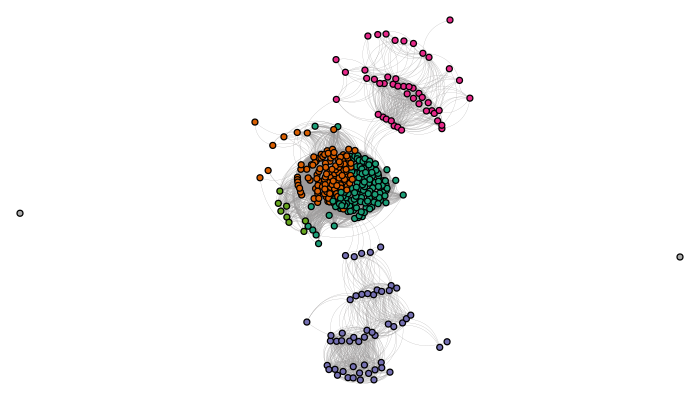

In [34]:
from IPython.display import Image

igraph.plot(graph, "../data/model_modsar_morgan2_graph.png", 
            layout=layout, vertex_size=6, vertex_label=None, 
            vertex_color=[color_dict[comm] for comm in graph.vs["community"]],
            edge_color="#9c9a9a", edge_curved=True, edge_width=0.2,
            background=None,
            vertex_frame_width=1.3,
            bbox=[700, 400], margin=20)

Image("/mnt/data/model_modsar_morgan2_graph.png")

**Observations:**

- Note how modules m01 and m02 are intraconnected, molecules in these modules are very similar to each other
- There are also a lot of inter-connections between these two modules (m01 and m02)
- Module m05 seems to represent a set of of compounds similar - but not too similar - to these two main modules
- Modules m03 and m04 are very distinct. It is even possible that they could be further broken down into sub-modules

## Equivalence OSM Series vs Module

OSM data contain different sets of analogues (Series 1 - Series 4). Here we see that the modular structure of the network identified by modSAR captures this heterogeinity automatically. There is a direct relationship between the modules and OSM Series


_Minor FIXME: The notebook uses networkx and igraph to handle the graph. It might be best and easier to stick to just one library in the future_

In [35]:
import networkx as nx

from nx_altair.core import to_pandas_nodes

G = nx.read_gml("../data/model_modsar_morgan2_graph.gml")
# pos = nx.kamada_kawai_layout(G, scale=0.6)

In [37]:
molecules_df = to_pandas_nodes(G, pos)

molecules_df = pd.merge(molecules_df, 
                        dataset_morgan2.metadata[["Canonical_Smiles"]], 
                        left_index=True, 
                        right_index=True)

molecules_df.head()

,x,community,Series,degree,y,louvain,Canonical_Smiles
OSM-A-1,0.4393,m03,1,29,0.181697,m01,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...
OSM-A-2,0.560044,m03,1,28,0.177073,m01,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...
OSM-A-3,0.432381,m03,1,29,0.221518,m01,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...
OSM-E-1,0.351108,m03,1,20,-0.000414354,m01,CN(CC(=O)N)S(=O)(=O)c1cc(C)n(c1C)c2ccc(F)cc2
OSM-E-2,0.327046,m03,1,22,0.0705779,m01,Cc1cc(c(C)n1c2ccc(F)cc2)S(=O)(=O)NCC(=O)N


In [38]:
osm_series = molecules_df.Series
osm_series = osm_series.apply(lambda x: '4' if x == 'not4' else ('1' if x == 'TB' else x))
osm_series.name = "OSM Data"
osm_series = osm_series.apply(lambda x: 'Series '+x)

modules = molecules_df.community
modules.name = "Modules"

pd.crosstab(modules, osm_series)

OSM Data,Series 1,Series 2,Series 3,Series 4
Modules,,,,
m01,0,0,0,121
m02,0,1,0,116
m03,52,0,0,0
m04,0,0,47,0
m05,0,0,0,8
singleton,1,0,1,0


## Outlier: S2 compound in S4 module

In [39]:
molecules_df[(molecules_df["community"] == "m02") & (molecules_df["Series"] == "2")]

,x,community,Series,degree,y,louvain,Canonical_Smiles
OSM-S-66,0.105442,m02,2,2,0.151298,m06,C(Sc1nc[nH]n1)c2ccccc2


How does this molecule look like?

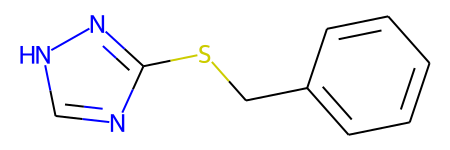

In [63]:
s2_outlier = Chem.MolFromSmiles(molecules_df.loc["OSM-S-66"]["Canonical_Smiles"])
s2_outlier

How is it related to S4 compounds? What are its neighbours in the graph? And what do they have in common?

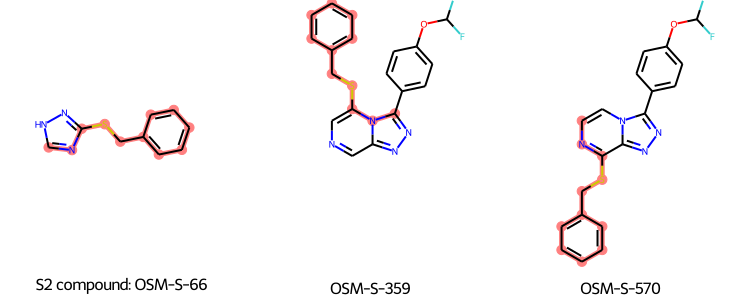

In [64]:
neighs = graph.neighbors(graph.vs.find(label="OSM-S-66"))
mols = [s2_outlier]
mols_labels = ['S2 compound: OSM-S-66']
for idx in neighs:
    osm_id = graph.vs[idx]["label"]
    neighbour_mol = Chem.MolFromSmiles(molecules_df.loc[osm_id]["Canonical_Smiles"])
    AllChem.GenerateDepictionMatching2DStructure(neighbour_mol, s4_template)
    mols.append(neighbour_mol)
    mols_labels.append(osm_id)

mcs_substructure = Chem.MolFromSmarts(rdFMCS.FindMCS(mols).smartsString)
    
Draw.MolsToGridImage(mols,legends=mols_labels,
                     highlightAtomLists=[mols[i].GetSubstructMatch(mcs_substructure) 
                                         for i in range(len(mols))] ,
                     subImgSize=(250,300), useSVG=False)

# Analysis of Modules

Now, can we get a sense of what these modules mean? What are the dominant scaffold/structures on each module?


In [65]:
from rdkit.Chem.Scaffolds import rdScaffoldNetwork
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Draw.MolDrawing import DrawingOptions

def get_scaffold_pattern(df, smiles_col='Canonical_Smiles'):
    params = rdScaffoldNetwork.ScaffoldNetworkParams() 
    params.includeGenericScaffolds = False
    params.includeGenericBondScaffolds = False
    params.includeScaffoldsWithoutAttachments=False
    
    smiles_mols = [smiles_code for smiles_code in df[smiles_col]]
    mols = [Chem.MolFromSmiles(smiles_code) for smiles_code in smiles_mols]
    
    net = rdScaffoldNetwork.CreateScaffoldNetwork(mols, params)
    return net

def get_mcs_pattern(df, smiles_col='Canonical_Smiles'):
    mols = [Chem.MolFromSmiles(smiles_code) for smiles_code in df[smiles_col]]
    res = rdFMCS.FindMCS(mols)
    pattern = Chem.MolFromSmarts(res.smartsString)
    return pattern

def get_representative_scaffold(module_df, smiles_col='Canonical_Smiles'):
    """
    Use rdkit.Chem.Scaffolds.rdScaffoldNetwork to identify the most dominant scaffolds in this module.
    
    This function returns the most representative scaffolds - the ones present in at least 50% of structures.
    
    Reference: https://pubs.acs.org/doi/10.1021/acs.jcim.0c00296
    """
    
    net = get_scaffold_pattern(module_df, smiles_col)

    df = pd.DataFrame({'pattern': net.nodes, 'count': net.counts})
    df['pctg'] = df["count"].apply(lambda x: x/module_df.shape[0])
    df = df[(df["pctg"] < 1) & (df["pctg"] > 0.5)].copy()
    df['pctg'] = df['pctg'].apply(lambda x: "%.2f %%" % (100*x))

    def generate_depiction(x):
        m = Chem.MolFromSmiles(x)
        if m.HasSubstructMatch(s4_template):
            AllChem.GenerateDepictionMatching2DStructure(m, s4_template)
        return m

    df["scaffold"] = df["pattern"].apply(generate_depiction)
    
#     PandasTools.AddMoleculeColumnToFrame(df,'pattern','scaffold',includeFingerprints=True)
    return df.sort_values('count', ascending=False)

def plot_representative_of_module(df, selected_module, 
                                  smiles_col='Canonical_Smiles', align_pattern=None, 
                                  folder="/mnt/data/results/OSM_model_round2/"):
    
    module_df = df[df['community'] == selected_module]
    
    module_subgraph = G.subgraph([node[0] for node in G.nodes(data=True) 
                                  if node[1]['community'] == selected_module])
    degrees = pd.DataFrame(sorted(module_subgraph.degree(), key=lambda x: x[1], reverse=True), 
                           columns=["index","node_degree"])
    degrees.set_index("index", inplace=True)
    
    idx = 0
    while idx < len(degrees):
        try:
            highest_degree_id = degrees.index[idx]
            #highest_degree_id = module_df['degree'].astype(int).idxmax()
            print("Representative molecule of module {} selected: {}".format(selected_module, highest_degree_id))
            highest_degree_mol = Chem.MolFromSmiles(module_df.loc[highest_degree_id]['Canonical_Smiles'])
            print("Canonical Smiles: ", module_df.loc[highest_degree_id]['Canonical_Smiles'])

            module_pattern = get_representative_scaffold(module_df, smiles_col='Canonical_Smiles')
            module_pattern = Chem.MolFromSmarts(module_pattern["pattern"].iloc[0])

            if align_pattern is not None:
                AllChem.Compute2DCoords(align_pattern)
                AllChem.GenerateDepictionMatching2DStructure(highest_degree_mol, align_pattern)

            matching = highest_degree_mol.GetSubstructMatch(module_pattern)
            hit_bonds = []
            for bond in module_pattern.GetBonds():
                aid1 = matching[bond.GetBeginAtomIdx()]
                aid2 = matching[bond.GetEndAtomIdx()]
                hit_bonds.append(highest_degree_mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
            break
        except Exception as e:
            print(e)
            idx = idx + 1
        
        
    drawing_opts = DrawingOptions()
    drawing_opts.bgColor=None
    drawing_opts.colorBonds = False
    drawing_opts.includeAtomNumbers = True
    
    filename = '%s/%s_%s_pattern.png' % (folder, selected_module, highest_degree_id)
    print("Saving %s" % filename)
    Chem.Draw.MolToFile(highest_degree_mol, filename, size=(400, 300),
                        highlightAtoms=matching, highlightBonds=hit_bonds, 
                        kekulize=True,
                        options=drawing_opts)
    
    return  Chem.Draw.MolToImage(highest_degree_mol,
                     size=(400, 300), kekulize=True, 
                     highlightAtoms=matching, highlightBonds=hit_bonds,
                     options=drawing_opts,)


**Example: Series 4 - Generic Scaffold**

Beforing looking at modules, let us select the compounds labelled Series 4 and see which scaffolds are identified

,pattern,count,pctg,scaffold
4,*c1cncc2nnc(-c3ccccc3)n12,178,83.57 %,
13,*c1nnc2cncc(OCCc3ccccc3)n12,120,56.34 %,

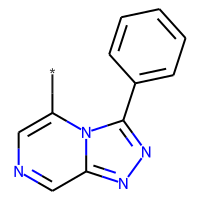
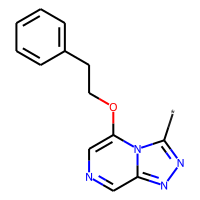

In [70]:
s4_scaffolds = get_representative_scaffold(molecules_df[molecules_df['Series'] == "4"])

s4_dominant_scaffold = Chem.MolFromSmarts(s4_scaffolds['pattern'].iloc[0])

s4_scaffolds

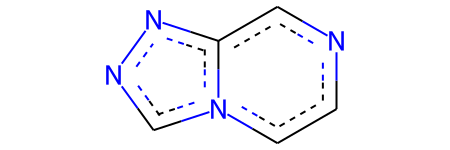

In [158]:
s4_pattern = get_mcs_pattern(molecules_df[molecules_df['Series'] == "4"])
# s4_pattern.Compute2DCoords()
s4_pattern

## Series 4 modules

The first promissing compounds released by MMV and Pfizer were OSM-S-272 and OSM-S-218.

OSM-S-272 is present in our dataset and were set into the module m01:

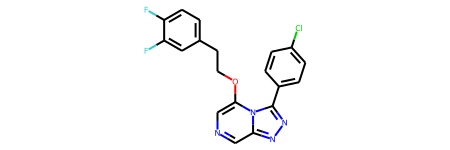

In [71]:
mol = Chem.MolFromSmiles(molecules_df["Canonical_Smiles"].loc["OSM-S-272"])
AllChem.GenerateDepictionMatching2DStructure(mol, s4_template)
mol

How many neighbours do this compound have in our graph? And where are they located? In which modules?

In [72]:
pd.Series(graph.vs[graph.neighbors(graph.vs.find(label="OSM-S-272"))]["community"]).value_counts()

m01    115
m02    101
dtype: int64

As we can see, almost all chemical compounds in modules m01 (115/121) and m02 (101/116) are connected to OSM-S-272.

### Module m01

Module m01 is the largest in the graph. We can look at the most representative scaffolds and elect a representative molecule from the module.

The table below shows the scaffold and the percentage of structures within module m01 that exhibit that substructure

,pattern,count,pctg,scaffold
3,*c1nnc2cncc(OCCc3ccccc3)n12,97,80.17 %,
4,*c1cncc2nnc(-c3ccccc3)n12,67,55.37 %,

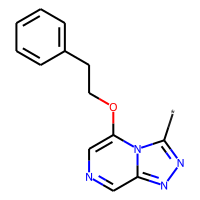
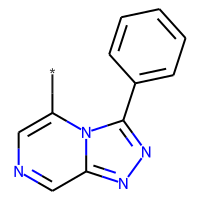

In [73]:
get_representative_scaffold(molecules_df[molecules_df['community'] == "m01"])

**REPRESENTATIVE MOLECULE**

Representative molecule of module m01 selected: OSM-S-408
Canonical Smiles:  C(Cc1ccccc1)Oc2cncc3nnc(c4ccncc4)n23
Saving /mnt/data/results/OSM_model_round2//m01_OSM-S-408_pattern.png


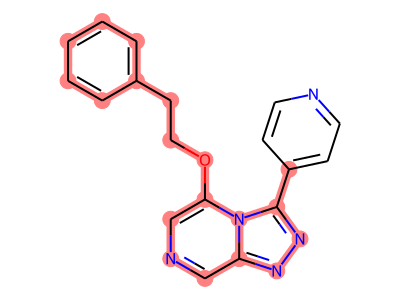

In [81]:
plot_representative_of_module(molecules_df, selected_module='m01', align_pattern=s4_template)

### Module m02

The second largest module is also composed of OSM Series4 compounds but has a different scaffold compared to m01:

,pattern,count,pctg,scaffold
6,*c1cncc2nnc(-c3ccccc3)n12,111,94.87 %,

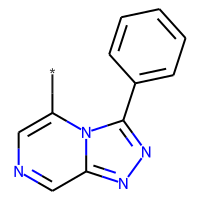

In [82]:
get_representative_scaffold(molecules_df[molecules_df['community'] == "m02"])

**REPRESENTATIVE MODULE m02**

Representative molecule of module m02 selected: OSM-S-175
Canonical Smiles:  FC(F)Oc1ccc(cc1)c2nnc3cncc(C(=O)Nc4ccnc(c4)C(F)(F)F)n23
Saving /mnt/data/results/OSM_model_round2//m02_OSM-S-175_pattern.png


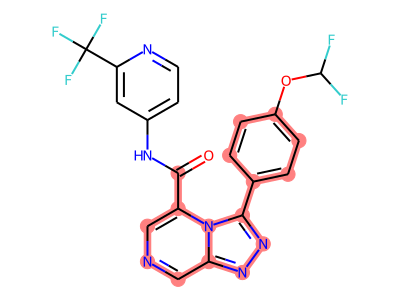

In [83]:
plot_representative_of_module(molecules_df, selected_module='m02', align_pattern=s4_template)

### Module m05

Another module identified by modSAR that is composed entirely of OSM-S4 molecules is m05:

,pattern,count,pctg,scaffold
4,*c1nccn2c(-c3ccccc3)nnc12,7,87.50 %,

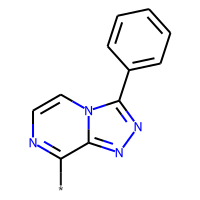

In [84]:
get_representative_scaffold(molecules_df[molecules_df['community'] == "m05"])

Representative molecule of module m05 selected: OSM-S-628
Canonical Smiles:  C(Cc1ccccc1)Sc2nccn3c(nnc23)c4ccccc4
Saving /mnt/data/results/OSM_model_round2//m05_OSM-S-628_pattern.png


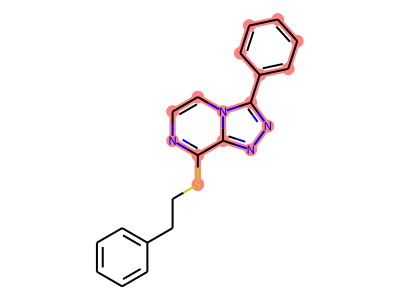

In [85]:
plot_representative_of_module(molecules_df, selected_module='m05', align_pattern=s4_template)

## Series 01 - Module m03

We can do the same thing for the module associated with OSM Series 1

,pattern,count,pctg,scaffold
2,*c1ccn(-c2ccccc2)c1,43,82.69 %,

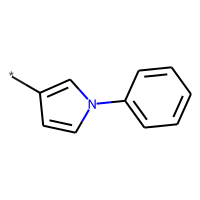

In [86]:
get_representative_scaffold(molecules_df[molecules_df['community'] == "m03"])

Representative molecule of module m03 selected: OSM-S-10
Canonical Smiles:  Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4ccc(F)cc4
Saving /mnt/data/results/OSM_model_round2//m03_OSM-S-10_pattern.png


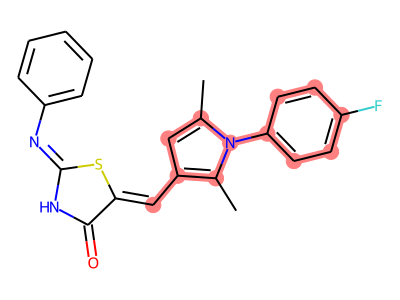

In [87]:
plot_representative_of_module(molecules_df, selected_module='m03')

## Series 03 - Module m04

,pattern,count,pctg,scaffold
3,*c1cc2ncncc2s1,31,65.96 %,

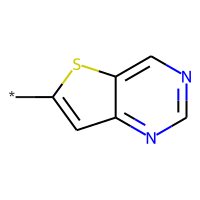

In [88]:
get_representative_scaffold(molecules_df[molecules_df['community'] == "m04"])

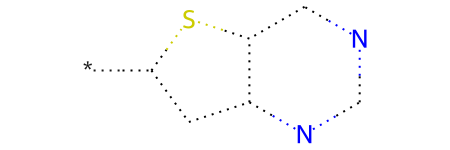

In [89]:
s3_pattern = get_representative_scaffold(molecules_df[molecules_df['community'] == "m04"])
Chem.MolFromSmarts(s3_pattern["pattern"].values[0])

Representative molecule of module m03 selected: OSM-S-106
Canonical Smiles:  Nc1ncnc2cc(sc12)c3cccc(c3)S(=O)(=O)N
Saving /mnt/data/results/OSM_model_round2//m03_OSM-S-106_pattern.png


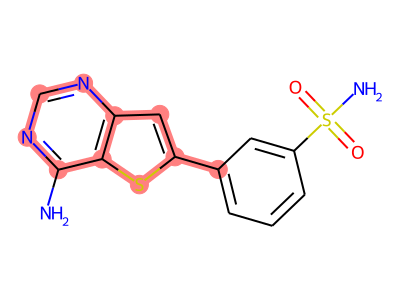

In [45]:
plot_representative_of_module(molecules_df, selected_module='m03')

# Piecewise models

Every module in the graph (m01, m02, m03, etc.) is predicted by a [piecewise model](http://doi.wiley.com/10.1002/minf.201800028) that we can uncover from the `<modSAR obj>.get_model_info()` function.

In [104]:
modsar_alg.models

{'m01': OplraRegularised(lam=0.06, solver_name='cplex'),
 'm02': OplraRegularised(lam=0.06, solver_name='cplex'),
 'm06': OplraRegularised(lam=0.06, solver_name='cplex'),
 'm03': OplraRegularised(lam=0.06, solver_name='cplex'),
 'm04': OplraRegularised(lam=0.06, solver_name='cplex'),
 'm05': OplraRegularised(lam=0.06, solver_name='cplex'),
 'm07': OplraRegularised(lam=0.06, solver_name='cplex')}

\#_FIXME: modsar_alg.models is showing the modules original names_

In [105]:
def get_linear_equation(row):
    coeffs = ['%+.2f %s' % (val, coeff) for coeff, val in row.iteritems() 
              if not (math.isnan(val) or float(val) == 0) and coeff != 'B']
    equation_str = ' '.join(coeffs)
    equation_str += " %+.2f" % row['B']    
    return equation_str  

def print_module_equations(coeffs, module):
    """Helper function to print a clean representation of piecewise equations for informed module"""
    
    coeffs = coeffs.query('module == "%s"' % module)

    for idx, row in coeffs.groupby(['module', 'region']):
        equation = get_linear_equation(row.drop(columns=['module', 'region']))
        print('Equations for Module %s | Region %d\n' % (idx[0], idx[1] + 1))
        print("pIC50 = ", equation)
        print()

In [106]:
coeff, breakpoints = modsar_alg.get_model_info()

The model info informs which feature (which Bit) was used to split the module in two disjoint regions:

In [108]:
breakpoints.sort_values(by="module")

,module,region,breakpoints,fStar
0,m01,0,0.01,Bit_0350
1,m02,0,None,None
3,m03,0,0.01,Bit_0484
4,m04,0,None,None
5,m05,0,0.01,Bit_0890
2,m06,0,0.01,Bit_0875
6,m07,0,None,None


The coeff dataframe contains the regression coefficients for each bit

In [107]:
coeff.sort_values(by="module")

,module,region,Bit_0031,Bit_0036,Bit_0080,Bit_0290,Bit_0332,Bit_0389,Bit_0480,Bit_0703,Bit_0745,Bit_0961,Bit_1017,Bit_0114,Bit_0409,Bit_0768,Bit_0650,Bit_0896,Bit_0926,B
0,m01,0,0.23842,0.191988,-0.189381,0.333412,0.12861,0.207109,0.109993,0.12861,-0.700626,0.092265,0.377418,NaN,NaN,NaN,NaN,NaN,NaN,5.191037
1,m01,1,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,4.301030
2,m02,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.607303
5,m03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10721,-0.09691,0.09691,NaN,NaN,NaN,4.397940
6,m03,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,NaN,NaN,NaN,5.466139
7,m04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.397940
8,m05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,4.602060
9,m05,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.357678,0.692932,-0.056648,5.357678
3,m06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
4,m06,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.153663


In [114]:
from oplrareg import OplraPyomoModel

def get_id_mols_in_module(graph, module):
    idx = np.argwhere(np.array(graph.vs["louvain"]) == module).flatten().tolist()
    return graph.vs[idx]["label"]

def get_oplra_model_and_features(modsar_model, module, dataset):
    
    id_mols = get_id_mols_in_module(modsar_model.instance_graph, module)
    data = dataset.X.loc[id_mols]
    
    oplra_model = modsar_model.models[module]
    
    fStar = oplra_model.final_model.fStar
    selected_features = oplra_model.final_model.get_selected_features(add_fstar=True)
    
    filtered_X = data.loc[:, selected_features]
    
    return oplra_model, filtered_X

In [95]:
from ipywidgets import interact,fixed,IntSlider
def renderFpBit(mol,bitIdx,bitInfo,fn):
    bid = bitIdx
    return(display(fn(mol,bid,bitInfo)))


def show_bits(dataset, id_mols, idx):
    smiles = dataset.metadata.Canonical_Smiles.loc[id_mols]
    rdkit_mols = [Chem.MolFromSmiles(mol) for mol in smiles]

    bi = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(rdkit_mols[idx], radius=2, nBits=1024, bitInfo=bi)

    bits = list(bi.keys())

    return interact(renderFpBit, bitIdx=list(bi.keys()),mol=fixed(rdkit_mols[idx]),
             bitInfo=fixed(bi),fn=fixed(Draw.DrawMorganBit));

## Example: Module m01

So for example, the largest module in the network is m01 (m05 was its original name). By inspecting the `breakpoints` dataframe above, we see that compounds have been split into two subgroups following the rules:


$\text{Bit_0890} = 0$ -> Region 01 (contains 30 chemicals)

$\text{Bit_0890} = 1$ -> Region 02 (contains 91 chemicals)

In [121]:
id_mols = get_id_mols_in_module(graph, "m05") #m01 was named m05 originally
bit_presence = dataset_morgan2.X.loc[id_mols]["Bit_0890"].value_counts()

bit_presence.to_frame().sort_index()

,Bit_0890
0,30
1,91


Now if we look at the piecewise equations that represent these subgroups of module m01:

- Compounds in Region 01 are all predicted to be inactive with $pIC_{50} = 4.60$. These compounds do not have bit 0890. 
- Compounds in Region 02 have the bit 0890 and are predicted by a linear equation that combines other bits: bit_0650, bit_0896, bit_0926. Compounds of this subgroup are predicted to be active if Bit 0896 is present - that is assuming an activity cutoff of $\ge 2.5 \mu M$ $(pIC_{50} \ge  5.60)$

In [111]:
print_module_equations(coeff, "m05") # m01 was named m05 originally

Equations for Module m05 | Region 1

pIC50 =   +4.60

Equations for Module m05 | Region 2

pIC50 =  -0.36 Bit_0650 +0.69 Bit_0896 -0.06 Bit_0926 +5.36



**But What does the Bit 0890 represent? What is the fragment that best expresses it?**

\# TODO: The code below should allow us to visualize the bits

https://www.rdkit.org/docs/GettingStartedInPython.html#explaining-bits-from-morgan-fingerprints

For some reason, the visualisation of Bit 0890 (below) is not working 🤔

Something must be wrong with the custom show_bits function

In [131]:
id_mols_contain_bit = np.array(id_mols)[dataset_morgan2.X.loc[id_mols]["Bit_0890"] == 1]

#show_bits(dataset_morgan2, id_mols_contain_bit, 50)

# WIP:

- Investigate piecewise models in depth
- Visualise the bits that are associated with an increase in activity within each module
- Investigate SHAP values of the piecewise equations (Ref: https://doi.org/10.1007/s10822-020-00314-0)

# Other

Generating S4 core by hand to align with figure

SMARTS:  [#6]1:[#7]:[#6]:[#6]:[#7]2:[#6]:1:[#7]:[#7]:[#6]:2


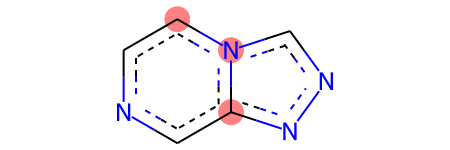

In [314]:
m = Chem.Mol()
em = Chem.EditableMol(m)
idx0 = em.AddAtom(Chem.Atom(6))
idx1 = em.AddAtom(Chem.Atom(7))
idx2 = em.AddAtom(Chem.Atom(6))
idx3 = em.AddAtom(Chem.Atom(6))
# idxEspecial = em.AddAtom(Chem.Atom(0))

idx4 = em.AddAtom(Chem.Atom(7))
idx5 = em.AddAtom(Chem.Atom(6))
idx6 = em.AddAtom(Chem.Atom(7))
idx7 = em.AddAtom(Chem.Atom(7))
idx8 = em.AddAtom(Chem.Atom(6))
# idxEspecial2 = em.AddAtom(Chem.Atom(0))

em.AddBond(idx0, idx1, rdkit.Chem.rdchem.BondType.AROMATIC)
em.AddBond(idx1, idx2, rdkit.Chem.rdchem.BondType.AROMATIC)
em.AddBond(idx2, idx3, rdkit.Chem.rdchem.BondType.AROMATIC)
em.AddBond(idx3, idx4, rdkit.Chem.rdchem.BondType.AROMATIC)
# em.AddBond(idx3, idxEspecial, rdkit.Chem.rdchem.BondType.UNSPECIFIED)

em.AddBond(idx4, idx5, rdkit.Chem.rdchem.BondType.AROMATIC)
em.AddBond(idx5, idx0, rdkit.Chem.rdchem.BondType.AROMATIC)
em.AddBond(idx5, idx6, rdkit.Chem.rdchem.BondType.AROMATIC)
em.AddBond(idx6, idx7, rdkit.Chem.rdchem.BondType.AROMATIC)
em.AddBond(idx7, idx8, rdkit.Chem.rdchem.BondType.AROMATIC)
em.AddBond(idx8, idx4, rdkit.Chem.rdchem.BondType.AROMATIC)
# em.AddBond(idx8, idxEspecial2, rdkit.Chem.rdchem.BondType.UNSPECIFIED)


m = em.GetMol()
# Chem.SanitizeMol(m)
# Chem.AddHs(m)
# AllChem.EmbedMolecule(m)
# AllChem.MMFFOptimizeMolecule(m)
# m.Compute2DCoords()
# m.__sssAtoms = [0]

print("SMARTS: ", Chem.MolToSmarts(m))
m = Chem.MolFromSmarts(Chem.MolToSmarts(m))
m.__sssAtoms=[3,4,5]
AllChem.Compute2DCoords(m)
m